# Skew-Confidence-Interval

An algorithm to estimate CI for distribution with high skew.

Generate a distribution $X~\exp{(N(\mu, \sigma))}+b$ with unique $\mu, \sigma, b$ match given $m, v, s$ (mean, variance and skewness).

### ps:

Only work when $s > 0$

Use normal when $s := 0$

Input $-s, -m$ when $s < 0$ and consider $-X$ finally.

In [29]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy
import matplotlib.pyplot as plt

In [25]:
def magic_cubic(x, b):
    # an cubic function to solve parameter of log normal from skewness
    return (x-1)*((x+2)**2) - b

def magic_cubic_deri(x):
    # derivative of cubic function above
    return 3*x*(x+2)

class ExpNormal():
    def __init__(self, mean, var, skew, newton_threshold=0.000001):
        assert skew > 0, "skewness error, expect positive value, got {}".format(skew)
        assert var > 0, "variance error, expect positive value, got {}".format(var)
        
        pow_sigma2 = 1 + skew/9
        for t in range(100):
            if magic_cubic(pow_sigma2, skew**2) < newton_threshold:
                break
            
            pow_sigma2 -= magic_cubic(pow_sigma2, skew**2)/magic_cubic_deri(pow_sigma2)
        
        pow_mu = (var/(pow_sigma2*(pow_sigma2 - 1)))**0.5
        self.bias = mean - pow_mu*(pow_sigma2**0.5)
        self.mu = np.log(pow_mu)
        self.sigma = np.sqrt(np.log(pow_sigma2))
    
    def ppf(self, percent):
        # percent point function
        assert (percent <= 1) and (percent >= 0), "percent error, expect 0~1, got {}".format(percent)
        
        return np.exp(self.mu + self.sigma*scipy.stats.norm.ppf(percent))+self.bias
    
    def pdf_sampling(self, sampling_rate: int = 1000):
        assert isinstance(sampling_rate, int), 'sampling_rate error, expect positive int, got {}'.format(type(sampling_rate))
        assert sampling_rate > 0, 'sampling_rate error, expect positive int, got {}'.format(sampling_rate)
        
        divide_rate_ends = (np.arange(sampling_rate+1)+0.5)/(sampling_rate+1)
        divide_rate_centers = (np.arange(1, sampling_rate+1))/(sampling_rate+1)
        centerpoints = np.zeros((sampling_rate))
        density = np.zeros((sampling_rate))
        for s in range(sampling_rate):
            centerpoints[s] = self.ppf(divide_rate_centers[s])
            density[s] = 1/((sampling_rate+1)*(self.ppf(divide_rate_ends[s+1]) - self.ppf(divide_rate_ends[s])))
        
        return centerpoints, density

## Test

Consider a condition, throw an unfair coin n times

Compare error to :
- Estimate error by normal distribution
- Significance Level

In [26]:
n = 100
p = 0.2

hits = np.arange(n+1) # 0,1,...,n

combine = (np.arange(n+1) < 2).astype(np.float64) # [1,1,0,0,...,0]
for t in range(n-1):
    combine[1:] += combine[:-1]

prob = combine * np.power(p, hits) * np.power(1-p, n - hits)

mean = (hits * prob).sum()
var = (((hits - mean)**2)*prob).sum()
skew = (((hits - mean)**3)*prob).sum()/(var**1.5)

exp_normal = ExpNormal(mean, var, skew)

for SL in [0.3, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]: #Significance Level
    n_CI = mean + np.sqrt(var)*scipy.stats.norm.ppf(1-SL)
    n_error = np.abs((prob*(hits>n_CI)).sum() - SL)
    
    l_CI = exp_normal.ppf(1-SL)
    l_error = np.abs((prob*(hits>l_CI)).sum() - SL)
    print("sl: %4f, error to sl: %4f, error to normal: %4f"%(SL, l_error/SL, l_error/n_error))

sl: 0.300000, error to sl: 0.129776, error to normal: 1.000000
sl: 0.200000, error to sl: 0.054564, error to normal: 1.000000
sl: 0.100000, error to sl: 0.125246, error to normal: 1.000000
sl: 0.050000, error to sl: 0.116654, error to normal: 1.000000
sl: 0.010000, error to sl: 0.124898, error to normal: 1.000000
sl: 0.001000, error to sl: 0.263116, error to normal: 0.478011
sl: 0.000100, error to sl: 0.381483, error to normal: 0.161585
sl: 0.000010, error to sl: 0.031621, error to normal: 0.021122


# Sampling

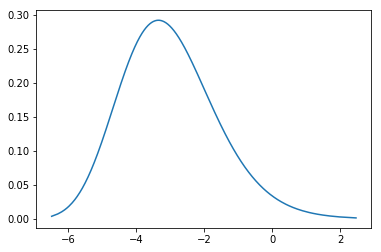

In [55]:
mean = -3
var = 2
skew = 0.5

exp_normal = ExpNormal(mean, var, skew)
sampling, density = exp_normal.pdf_sampling()
plt.plot(sampling, density)

## Table

skewness to significance level table for normalized distribution

In [27]:
sl = [0.3, 0.2, 0.1, 0.05, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08]
skew = (np.arange(20)+1)/20
table = np.zeros((20,1+len(sl)))
table[:,0] = skew
for i in range(20):
    exp_normal = ExpNormal(0., 1., skew[i])
    for j in range(len(sl)):
        table[i,j+1] = log_normal.ppf(1-sl[j])

pd.DataFrame(table, columns=["skew"]+sl)

,skew,0.3,0.2,0.1,0.05,0.01,0.001,0.0001,1e-05,1e-06,1e-07,1e-08
0,0.05,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
1,0.10,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
2,0.15,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
3,0.20,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
4,0.25,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
5,0.30,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
6,0.35,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
7,0.40,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
8,0.45,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
9,0.50,0.379731,0.744909,1.315548,1.850049,3.033188,4.698321,6.40293,8.182038,10.054821,12.034254,14.130422
